Underlying Principle
The principle is simple: we define two distances, one for the content (DC) and one for the style (DS). DC measures how different the content is between two images while DS measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image.


In [5]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
from functools import reduce, partial
from toolz import frequencies, partial, compose_left as pipe #seq
from toolz.curried import map as cmap, filter as cfilter
from visualization.modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#??torch.cuda
cuda = torch.cuda.is_available()
device = torch.device(cuda and "cuda" or "cpu")
resizer = transforms.Resize(cuda and 512 or 128)

The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images.

In [7]:
img_preprocess = pipe(
    Image.open,
    transforms.Compose(
        [resizer,  # scale imported image
    # desired size of the output image
    # use small size if no gpu
         transforms.ToTensor()]
    ),
    # fake batch dimension required to fit network's input dimensions
    partial(torch.unsqueeze,dim=0),
    lambda img: img.to(device, torch.float)
)

In [8]:
PATH = "images/"
style_img = img_preprocess(PATH + "picasso.jpg")
content_img = img_preprocess(PATH + "dancing.jpg")

In [9]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

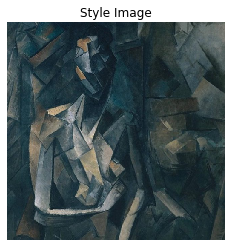

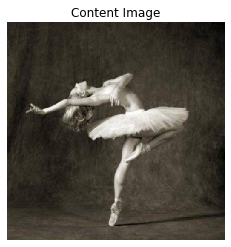

In [10]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions
### Content Loss

X = third image?
C = content image
L = Layer


The content loss is a function that represents a weighted version of the
content distance for an individual layer. The function takes the feature
maps $F_{XL}$ of a layer $L$ in a network processing input $X$ and returns the
weighted content distance $w_{CL}.D_C^L(X,C)$ between the image $X$ and the
content image $C$. The feature maps of the content image($F_{CL}$) must be
known by the function in order to calculate the content distance. We
implement this function as a torch module with a constructor that takes
$F_{CL}$ as an input. The distance $\|F_{XL} - F_{CL}\|^2$ is the mean square error
between the two sets of feature maps, and can be computed using ``nn.MSELoss``.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image the content losses will be
computed at the desired layers and because of auto grad, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a ``forward`` method that computes the content
loss and then returns the layer’s input. The computed loss is saved as a
parameter of the module.

In [11]:
cnn = models.vgg19(pretrained=True).features.to(device).eval() #features -> just conv and pooling
#eval -> behave the same at train and test

In [12]:
# create a module to normalize input image so we can easily put it in a
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [13]:
##idxs are too brittle if I change the children by injection!!!
style_injects = [
        #inject .  after:   n_th 
        (nn.Conv2d, 0),#inject styleloss after the 1st Conv2d layer in network
        (nn.Conv2d, 1),
        (nn.Conv2d, 2),
        (nn.Conv2d, 3),
        (nn.Conv2d, 4),
]

content_injects = [(nn.Conv2d, 3)]

In [14]:
arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

/home/jupyter/vision-playground/nbs/visualization/modules.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/jupyter/vision-playground/nbs/visualization/modules.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [15]:
arch

LayeredModule(
  (layers): ModuleList(
    (0): Normalization()
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU()
    (19): MaxPool2d(k

In [20]:
arch.hook_all_forward()

In [21]:
arch.hook_all_backward()

In [24]:
arch.layer_gradients

{}

In [26]:
arch(content_img)

AttributeError: 'Normalization' object has no attribute 'layer_outputs'

In [ ]:
style_module = StyleTransferModule(arch, content_img, content_injects, style_img, style_injects )

In [ ]:
style_module

In [ ]:
input_img = content_img.clone()

In [ ]:
style_module

In [ ]:
list(name for name,_ in style_module.layers.named_parameters())

In [ ]:
s = style_module.run_style_transfer(input_img, optim.LBFGS, verbose=True)

In [ ]:
imshow(s)

In [ ]:
s.size()

In [ ]:
for x in list(style_module._modules.items())[1][1]:
    print(x, "aa")

In [ ]:
for layer in list(style_module._modules.items())[1][1]:
    print(layer)

In [ ]:
visualisation = {}

def hook_fn(m, i, o):
    visualisation[m.__class__.__name__] = o 

def get_all_layers(net):
    for layer in list(net._modules.items())[1][1]:
        layer.register_forward_hook(hook_fn)

get_all_layers(style_module)


In [ ]:
visualisation

In [ ]:
list(style_module.children())[1][3].__class__.__name__

In [ ]:
out =  style_module.run_style_transfer(input_img, optim.LBFGS, verbose=True, num_steps=1)

In [ ]:
style_module.zero_grad

In [ ]:
#after you actually set a backward hook
def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [ ]:
visualisation.keys() #(Conv2d(3, 64, kernel_size=(3, 3)

In [ ]:
visualisation